In [88]:
import pandas as pd
import numpy as np
import json

import pickle 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

In [89]:
import os
import glob
def read_lines(fn):
    if not os.path.exists(fn):
        return []
    with open(fn, 'r', encoding='utf-8') as f:
        text = f.read()
    lines = text.split("\n")
    if lines[-1] == '':
        return lines[:-1]
    else:
        return lines

def write_lines(fn, lines, mode='w'):
    text_to_write = "\n".join(list(lines)) 
    with open(fn, encoding='utf-8', mode=mode) as f:
        f.write(text_to_write)

### WL

In [120]:
text_src = read_lines("../../data_parallel/wi+locness/train_src")
text_tgt = read_lines("../../data_parallel/wi+locness/train_tgt")

with open("../Clustering/data/wl_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/wl_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)

In [121]:
cos_sim_wl = []
for i in tqdm(range(len(vectors_src))):
    cos_sim_wl.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [122]:
# class CleanDataset:
#     def __init(self, text_src, text_tgt):
#         pass
    
#     def 

In [171]:
def show_statistic(df, len_before=0, show_rate=True):
    diff_len = len_before - len(df)
    print("Count of rows: ", len(df))
    if diff_len > 0:
        print("Diff count: ", diff_len)
    if show_rate==True:
        print("Count of rows with change: ", df['have_change'].sum())
        print("Rate of rows with change: ", round(df['have_change'].mean(),2))
    print()

def basic_clean(df, show = True, min_cos_src_tgt_sim = 0):
    len_start = len(df)
    print("Initial statistics")
    df['have_change'] = (df['text_src']!=df['text_tgt']).astype(int)
    show_statistic(df, len_start)
    
    print("Drop dulicates")
    len_before = len(df)
    df = df.drop_duplicates(subset=['text_src', 'text_tgt'])
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where len less 5 and less then 3 token")
    len_before = len(df)
    df = df[df["text_tgt"].str.len() > 5]
    df = df[df['text_tgt'].apply(lambda x: len(x.split(" ")) > 3)]
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where start from non-capital")
    len_before = len(df)
    df = df[df["text_tgt"].apply(lambda x: x[0] == x[0].upper())]
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where for one src more than one target")
    len_before = len(df)
    val_count = df.text_src.value_counts()
    index_to_delete = []
    for text_src in val_count[val_count > 1].index:
        sub_df = df[df.text_src == text_src]
        res_ind = sub_df[sub_df["cos_src_tgt"] > 0.999].index
        if len(res_ind):
            index_to_delete.extend(res_ind)
    df = df[~df.index.isin(index_to_delete)]
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where cosine similarity between src and tgt is less than ", min_cos_src_tgt_sim)
    len_before = len(df)
    df = df[df["cos_src_tgt"] > min_cos_src_tgt_sim]
    show_statistic(df, len_before, show_rate=True)
    
    print('Final rate of cleaned data: ', round(len(df)/len_start,2))
    return df

In [161]:
df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim_wl})

In [162]:
#df["cos_src_tgt"].describe()

In [173]:
clean_wl = basic_clean(df, show = True, min_cos_src_tgt_sim=0.75)

Initial statistics
Count of rows:  34308
Count of rows with change:  22744
Rate of rows with change:  0.66

Drop dulicates
Count of rows:  33493
Diff count:  815
Count of rows with change:  22717
Rate of rows with change:  0.68

Drop where len less 5 and less then 3 token
Count of rows:  32343
Diff count:  1150
Count of rows with change:  22566
Rate of rows with change:  0.7

Drop where start from non-capital
Count of rows:  32083
Diff count:  260
Count of rows with change:  22379
Rate of rows with change:  0.7

Drop where for one src more than one target
Count of rows:  32071
Diff count:  12
Count of rows with change:  22379
Rate of rows with change:  0.7

Drop where cosine similarity between src and tgt is less than  0.75
Count of rows:  31490
Diff count:  581
Count of rows with change:  21798
Rate of rows with change:  0.69

Final rate of cleaned data:  0.92


In [20]:
df = df.drop_duplicates(subset=['text_src', 'text_tgt'])

In [21]:
len(df)

33493

In [23]:
df[df["text_tgt"].str.len() <= 5]

,text_src,text_tgt,cos_src_tgt
288,Bye,Bye,1.0
429,Tracy,Tracy,1.0
553,"Hi ,","Hi ,",1.0
565,Steve,Steve,1.0
580,Ola,Ola,1.0
...,...,...,...
32572,Wydra,Wydra,1.0
33144,Samia,Samia,1.0
33212,Price,Price,1.0
33647,For,For,1.0


In [24]:
df = df[df["text_tgt"].str.len() > 5]

In [13]:
len(df)

33340

In [25]:
df[df["text_tgt"].apply(lambda x: x[0] != x[0].upper())]

,text_src,text_tgt,cos_src_tgt
49,because it 's difficult to understand ; for ex...,because it 's difficult to understand ; for ex...,1.000000
52,scary .,scary .,1.000000
54,from a story their mom read often .,from a story their mom often reads .,0.991840
56,used in other times .,used in other times .,1.000000
58,had a weird painting of two sisters just like ...,had a weird painting of two sisters just like ...,0.993085
...,...,...,...
33476,"pastimes , when I cook it 's usually for a big...","pastimes . When I cook , it 's usually for a b...",0.988201
33477,really enjoy .,really enjoy .,1.000000
33643,programme .,programme .,1.000000
33648,"example , is there _ park or cinema nearby ?","example , is there a park or cinema nearby ?",0.978424


In [26]:
df = df[df["text_tgt"].apply(lambda x: x[0] == x[0].upper())]

In [27]:
len(df)

33045

<AxesSubplot:ylabel='Frequency'>

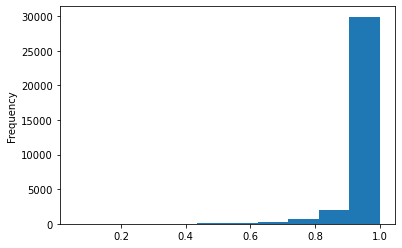

In [28]:
df["cos_src_tgt"].plot.hist()

In [156]:
df_sort = df.sort_values("cos_src_tgt")

In [182]:
df_sort[df_sort["cos_src_tgt"] <= 0.9]

,text_src,text_tgt,cos_src_tgt,have_change
2380,I am stydying envaermantal saents .,I am studying environmental science .,0.057646,1
2557,And terolism is scare also .,And terrorism is scarce also .,0.166419,1
13529,Good Morning :,Dear Sir / Madam,0.186326,1
5518,fsdjgdofg,,0.196443,1
23629,Rest is anything but completely different .,The rest is completely different .,0.201329,1
...,...,...,...,...
24042,Dear MR . Smith,Dear Mr . Smith,0.899792,1
2239,They collect house hold waste in a dustbin and...,They collect household waste in a dustbin and ...,0.899825,1
6165,I have to say that study another language give...,I have to say that studying another language g...,0.899843,1
5848,What I like most in this game is that The fewe...,What I like most about this game is that the s...,0.899913,1


In [84]:
df.loc[2943,'text_src']

'However , I was too dizzy to go straight so that I took a ride .'

In [83]:
df.loc[2943,'text_tgt']

'However , I was too dizzy to walk straight so that I took a taxi .'

In [31]:
df = df[df["cos_src_tgt"] > 0.75]

In [33]:
32418/34308

0.9449108079748164

In [32]:
len(df)

32418

In [44]:
df = df[df['text_tgt'].apply(lambda x: len(x.split(" ")) > 3)]

In [45]:
len(df)

31502

In [46]:
df.head(2)

,text_src,text_tgt,cos_src_tgt
0,My town is a medium size city with eighty thou...,My town is a medium - sized city with eighty t...,0.993933
1,It has a high density population because its s...,It has a high - density population because of ...,0.990306


In [57]:
val_count = df.text_src.value_counts()

In [55]:
len(val_count[val_count > 1])

15

In [56]:
val_count[val_count > 1]

In the summer around the lake are so many concerts so you have the difficulty finding the right one .    2
To sum up , there are lot of cleary strong arguments for against keeping animals in zoo .                2
In my opinion people should bulid some kind of wildlife parks . This solution will allow                 2
But lot of peoples saying that , the zoo can protected endagered spices against illegal poachers .       2
Aactivist of animals rights claimed that the reason is the keeping animals in zoo .                      2
Dear sir or madam ,                                                                                      2
All the best .                                                                                           2
Sometimes I play golf and I think it 's pretty fun , I like to be out with our sail boat .               2
So what should we do with that problem ?                                                                 2
I love it .                          

In [52]:
df[df.text_src == "But lot of peoples saying that , the zoo can protected endagered spices against illegal poachers ."]

,text_src,text_tgt,cos_src_tgt
9570,"But lot of peoples saying that , the zoo can p...",But a lot of people say that a zoo can protect...,0.806661
9580,"But lot of peoples saying that , the zoo can p...","But lot of peoples saying that , the zoo can p...",1.000000


In [51]:
df.loc[9569].values

array(['Aactivist of animals rights claimed that the reason is the keeping animals in zoo .',
       'Aactivist of animals rights claim that the reason is keeping animals in zoos .',
       0.9479724168777466], dtype=object)

In [53]:
df.loc[9570].values

array(['But lot of peoples saying that , the zoo can protected endagered spices against illegal poachers .',
       'But a lot of people say that a zoo can protect endangered species from illegal poachers .',
       0.806660532951355], dtype=object)

In [58]:
df[df.text_src == "Dear Sir / Madam"]

,text_src,text_tgt,cos_src_tgt
4230,Dear Sir / Madam,"Dear Sir / Madam ,",0.987556
4736,Dear Sir / Madam,Dear Sir / Madam,1.000000


In [60]:
df[df.text_src == "Dear sir or madam ,"]

,text_src,text_tgt,cos_src_tgt
1943,"Dear sir or madam ,","Dear sir or madam ,",1.000000
20030,"Dear sir or madam ,","Dear Sir or Madam ,",0.844556


In [59]:
df[df.text_src == "I love it ."]

,text_src,text_tgt,cos_src_tgt
4672,I love it .,I love them .,0.922197
26888,I love it .,I loved it .,0.979061


In [61]:
df[df.text_src == "In my opinion people should bulid some kind of wildlife parks . This solution will allow"]

,text_src,text_tgt,cos_src_tgt
9573,In my opinion people should bulid some kind of...,"In my opinion , people should build some kinds...",0.883226
9583,In my opinion people should bulid some kind of...,In my opinion people should bulid some kind of...,1.000000


In [62]:
df.loc[9573].values

array(['In my opinion people should bulid some kind of wildlife parks . This solution will allow',
       'In my opinion , people should build some kinds of wildlife parks . This solution will allow',
       0.8832262754440308], dtype=object)

In [71]:
index_to_delete = []
for text_src in val_count[val_count > 1].index:
    sub_df = df[df.text_src == text_src]
    res_ind = sub_df[sub_df["cos_src_tgt"] > 0.999].index
    if len(res_ind):
        index_to_delete.extend(res_ind)

In [74]:
index_to_delete

[9582, 9583, 9580, 9579, 1943, 25823, 9581, 4792, 9222, 4736, 9578]

In [78]:
len(df)

31502

In [79]:
df = df[~df.index.isin(index_to_delete)]

In [80]:
len(df)

31491

In [87]:
31491/34308

0.917890870933893

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
train, dev = train_test_split(df, test_size=0.02, random_state=4)

In [83]:
train_src = train.text_src.values 
train_tgt = train.text_tgt.values 
dev_src = dev.text_src.values 
dev_tgt = dev.text_tgt.values 

In [84]:
path_save = "../../data_parallel/clean_wl/"

In [85]:
write_lines(path_save+"train_src", train_src, mode='w')
write_lines(path_save+"train_tgt", train_tgt, mode='w')
write_lines(path_save+"dev_src", dev_src, mode='w')
write_lines(path_save+"dev_tgt", dev_tgt, mode='w')

In [60]:
# with open("../Checkpoint_exp/wl_cos.pickle", "rb") as f:
#     cos_check_wl = pickle.load(f)

### Nucle

In [174]:
text_src = read_lines("../../data_parallel/nucle/nucle_src")
text_tgt = read_lines("../../data_parallel/nucle/nucle_tgt")

with open("../Clustering/data/nucle_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/nucle_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)

In [175]:
cos_sim = []
for i in tqdm(range(len(vectors_src))):
    cos_sim.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [176]:
with open("../Checkpoint_exp/nucle_cos.pickle", "rb") as f:
    cos_check = pickle.load(f)

In [177]:
df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim, "cos_check": cos_check})

In [178]:
len(df)

57151

In [180]:
basic_clean_nucle = basic_clean(df, show = True, min_cos_src_tgt_sim=0.935)

Initial statistics
Count of rows:  57151
Count of rows with change:  21834
Rate of rows with change:  0.38

Drop dulicates
Count of rows:  53681
Diff count:  3470
Count of rows with change:  21830
Rate of rows with change:  0.41

Drop where len less 5 and less then 3 token
Count of rows:  52343
Diff count:  1338
Count of rows with change:  21559
Rate of rows with change:  0.41

Drop where start from non-capital
Count of rows:  51967
Diff count:  376
Count of rows with change:  21328
Rate of rows with change:  0.41

Drop where for one src more than one target
Count of rows:  51944
Diff count:  23
Count of rows with change:  21328
Rate of rows with change:  0.41

Drop where cosine similarity between src and tgt is less than  0.935
Count of rows:  49177
Diff count:  2767
Count of rows with change:  18561
Rate of rows with change:  0.38

Final rate of cleaned data:  0.86


In [181]:
# df = df.drop_duplicates(subset=['text_src', 'text_tgt'])
# df = df[df['cos_src_tgt'] >= 0.935]
# df = df[df['cos_check'] >= 0.96]

In [105]:
#df[df['text_src']!=df['text_tgt']]

<AxesSubplot:ylabel='Frequency'>

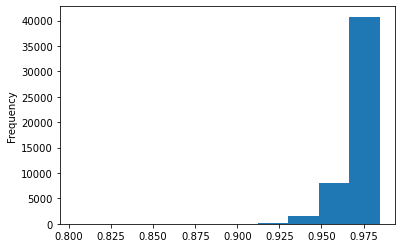

In [106]:
df['cos_check'].plot.hist()

In [109]:
df_sort = df.sort_values('cos_check')
df_sort[df_sort['cos_check']<=0.97]

,text_src,text_tgt,cos_src_tgt,cos_check
19571,Refereneces,Refereneces,1.000000,0.803712
10379,Introduction,Introduction,1.000000,0.866820
38255,2.COST,2.COST,1.000000,0.887483
38268,3.SECURITY,3.SECURITY,1.000000,0.891711
7708,( ST/ESA/SER.R/85 ) < { http : //db.jhuccp.org...,( ST/ESA/SER.R/85 ) < { http : //db.jhuccp.org...,1.000000,0.901031
...,...,...,...,...
35882,Nuclear fission fuel is inexhaustible .,Nuclear fission fuel is inexhaustible .,1.000000,0.969999
21679,The public will then need to assist his needs ...,The public will then need to assist them in or...,0.969285,0.969999
11105,"It consequently does ease the aging process , ...","It consequently does ease the aging process , ...",0.996917,0.969999
10841,These highly active grandchildren may become a...,These highly active grandchildren may become a...,1.000000,0.969999


In [15]:
df = df.sort_values('cos')

<AxesSubplot:ylabel='Frequency'>

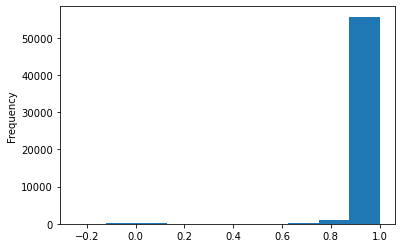

In [17]:
df['cos'].plot.hist()

In [102]:
df[df['cos_src_tgt'] <=0.935].sort_values("cos_src_tgt")

,text_src,text_tgt,cos_src_tgt,cos_check
14963,Even if a minority will have no intention to t...,.,-0.246615,0.974864
19124,It may be objected that despite great accommod...,,-0.228636,0.972713
27646,"Furthermore , the federal government ignored a...",,-0.216451,0.977595
30054,Normal employees are not inspirited also limit...,,-0.198910,0.973263
15812,This harsh behavior brings fear to adult who i...,,-0.188985,0.969514
...,...,...,...,...
7396,"In fact , governments should only focus on tho...","In fact , governments should only focus on tho...",0.934937,0.972960
21401,"Other charity organisations like the NKF , TOU...","Other charity organisations like the NKF , TOU...",0.934943,0.971466
12582,Children often expect their parents to contrib...,Children often expect their parents to contrib...,0.934955,0.980428
31328,"Therefore , the costs of aged should be borne ...","Therefore , the costs of spending for the shou...",0.934959,0.970989
